In [1]:
# Set up the state
from langgraph.graph import MessagesState, START, END
from langgraph.types import Command, interrupt
from langchain_core.messages import AIMessage, HumanMessage, ToolCall

from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel
from langchain_tavily import TavilySearch
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

from langgraph.checkpoint.memory import InMemorySaver
from IPython.display import Image, display

In [2]:
@tool
def search(location: str):
    """Call to get the weather at a location."""
    query = f"weather in {location}"
    print('Performing Web Search for: ', query)
    web_search_tool = TavilySearch(max_results=1, include_answer=True)
    search_response = web_search_tool.invoke({"query": query})
    
    return search_response

@tool
def ask_human(question):
    """Ask the human a question"""
    print('Asking human...')
    human_response = interrupt(question)
    return human_response

In [3]:
def build_model():
    model = ChatOpenAI(model="gpt-4")
    return model.bind_tools([search, ask_human])


def run_agent(state):
    print('Running agent...')
    model = build_model()

    response = model.invoke(state['query'])
    
    if response.tool_calls:
        tool_call = response.tool_calls[0]
        if tool_call["name"] == 'ask_human':
            human_response = ask_human.invoke(tool_call["args"])
            search_response = search.invoke({"location": human_response})
            state['web_search_response'] = search_response
    else:
        state['agent_response'] = response.content
    
    return state

In [4]:
# Build the graph
from langgraph.graph import END, StateGraph
from typing_extensions import TypedDict

class HumanInLoopState(TypedDict):
    """ State for the human in loop workflow. """
    query: str
    agent_response: AIMessage
    web_search_response: str | dict

# Define a new graph
workflow = StateGraph(HumanInLoopState)

# Define the three nodes we will cycle between
workflow.add_node("run_agent", run_agent)
workflow.add_edge(START, "run_agent")
workflow.add_edge("run_agent", END)

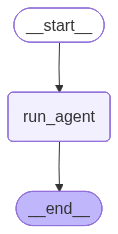

In [8]:
# Set up memory
memory = InMemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile(checkpointer=memory)

display(Image(app.get_graph().draw_mermaid_png()))

In [9]:
load_dotenv()
config = {"configurable": {"thread_id": "2"}}
response = app.invoke({
        "query": "Ask the user where they are, then look up the weather there"
    },
    config=config)

print(response)

Running agent...
Asking human...
{'query': 'Ask the user where they are, then look up the weather there', '__interrupt__': [Interrupt(value='Where are you currently located?', resumable=True, ns=['run_agent:c6c91fb5-bb34-10cb-88a8-58385a5ed9c1'])]}


In [10]:
response = app.invoke(Command(resume="San Francisco, California"), config=config)

print("\n\n======== Agent Response ======== \n")
print(response['web_search_response']['answer'])

Running agent...
Asking human...
Performing Web Search for:  weather in San Francisco, California


======== Agent Response ======== 

On August 25, 2025, San Francisco, California, will be partly cloudy with a temperature of 16°C (61°F). The wind will blow from the west at 6.9 mph (11.2 kph). Humidity is high at 87%.
